#### Name: Noha Magdy Ali 
#### ID: 1610126
# Age and Gender Recognition using openCV and CNNs 

### Needed packages 

In [1]:
from skimage import data, io
from matplotlib import pyplot as plt
import numpy as np
from skimage import img_as_ubyte,img_as_float
from skimage import data, io, filters
from matplotlib.pyplot import imshow, show
from skimage.morphology import watershed
from skimage.measure import label
from skimage.color import label2rgb
from skimage import feature
from skimage.filters import threshold_otsu,  threshold_local, sobel
from skimage.morphology import erosion,dilation,opening,closing,square,disk
from skimage.measure import label
from skimage.color import label2rgb
import os
import pandas as pd
!pip install -U tf-nightly
import tensorflow as tf
import functools
!pip install mitdeeplearning
import mitdeeplearning as mdl
from tqdm import tqdm
import cv2
from skimage.transform import rescale, resize
from skimage.color import rgb2gray
print(tf.__version__)



Requirement already up-to-date: tf-nightly in /usr/local/lib/python3.6/dist-packages (2.3.0.dev20200529)
2.3.0-dev20200529


### Loading and Preparing Data

In [0]:
# file_id = '0BxYys69jI14kSVdWWllDMWhnN2c'
# request = drive_service.files().get_media(fileId=file_id)
# fh = io.BytesIO()
# downloader = MediaIoBaseDownload(fh, request)
# done = False
# while done is False:
#     status, done = downloader.next_chunk()
#     print ("Download %d%%." % int(status.progress() * 100))

# !wget -P /usr https://drive.google.com/drive/u/0/folders/0BxYys69jI14kSVdWWllDMWhnN2c

# my_tar = tarfile.open("/usr/0BxYys69jI14kSVdWWllDMWhnN2c.tar.gz")
# my_tar.extractall('/usr/Dataset') # specify which folder to extract to
# my_tar.close()




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path= "/content/drive/My Drive/Dataset/"
data= os.listdir(path)
#print (data)
Data = pd.DataFrame(columns=["Image", "Age", "Gender"])


for idx,i in zip(range(len(data)),data):
    age, gender, race, name=i.split("_")
    img = io.imread(path+i)
    img = resize(img, (512, 512))
    img = rgb2gray(img)
    img=img_as_ubyte(img)
    img=np.array(img)
    Data.loc[idx] = [ img, age, np.int32(int(gender))]
    #append(pd.Series(data={"Image":img, "Age":age, "Gender":gender}, name=idx))

In [5]:
Data.shape

(3251, 3)

In [6]:
Data.head()

,Image,Age,Gender
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",61,0
1,"[[153, 174, 196, 206, 207, 205, 206, 206, 206,...",40,0
2,"[[253, 253, 253, 252, 252, 252, 251, 252, 252,...",45,0
3,"[[30, 27, 47, 67, 90, 105, 95, 86, 88, 91, 91,...",41,0
4,"[[177, 177, 177, 178, 178, 178, 179, 179, 181,...",54,0


In [7]:
rand_idxs = np.random.choice(Data.shape[0], 500, True)
test = Data.loc[rand_idxs]
train = Data
train.drop(rand_idxs)

,Image,Age,Gender
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",61,0
1,"[[153, 174, 196, 206, 207, 205, 206, 206, 206,...",40,0
2,"[[253, 253, 253, 252, 252, 252, 251, 252, 252,...",45,0
3,"[[30, 27, 47, 67, 90, 105, 95, 86, 88, 91, 91,...",41,0
4,"[[177, 177, 177, 178, 178, 178, 179, 179, 181,...",54,0
...,...,...,...
3242,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",55,0
3244,"[[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, ...",68,0
3245,"[[180, 180, 180, 180, 180, 180, 180, 180, 180,...",70,0
3247,"[[127, 127, 127, 127, 127, 127, 127, 127, 127,...",65,0


In [8]:
train.head()

,Image,Age,Gender
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",61,0
1,"[[153, 174, 196, 206, 207, 205, 206, 206, 206,...",40,0
2,"[[253, 253, 253, 252, 252, 252, 251, 252, 252,...",45,0
3,"[[30, 27, 47, 67, 90, 105, 95, 86, 88, 91, 91,...",41,0
4,"[[177, 177, 177, 178, 178, 178, 179, 179, 181,...",54,0


In [9]:
test.head()

,Image,Age,Gender
3184,"[[213, 213, 213, 213, 213, 213, 213, 213, 213,...",40,0
618,"[[28, 28, 27, 27, 26, 25, 24, 23, 22, 21, 21, ...",29,1
2837,"[[198, 198, 198, 198, 199, 199, 199, 200, 200,...",54,1
2882,"[[242, 242, 242, 241, 241, 240, 239, 238, 237,...",56,0
691,"[[209, 210, 212, 212, 210, 209, 209, 212, 216,...",60,0


In [10]:
x = np.array([[np.array([1,2,3]),[1,2,3]]])
print (x)
x_tf = tf.convert_to_tensor(x)
print (type(x_tf))

[[[1 2 3]
  [1 2 3]]]
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [0]:
def get_batch(x):
  rand_idxs = np.random.choice(train.shape[0], x, True)

  x = (train.loc[rand_idxs]["Image"]).to_numpy()
  img = np.zeros((x.shape[0],512,512))
  for idx in range((x.shape[0])):
    img[idx]=x[idx]
  img= np.expand_dims(img,-1)
  
  y = train.loc[rand_idxs]["Gender"].to_numpy()
  lab = np.zeros((y.shape[0]))
  for idx in range((y.shape[0])):
    lab[idx]=y[idx]
  lab= np.expand_dims(lab,-1)
  
  return img,lab


In [0]:
n_filters = 12 

def classifier(n_outputs=1):
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
    return model
My_classifier = classifier()

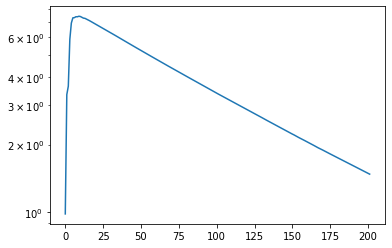

100%|██████████| 101/101 [05:31<00:00,  3.28s/it]


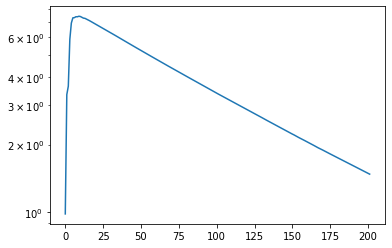

In [13]:
# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4
tf.keras.backend.set_floatx('float64')

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
    
    with tf.GradientTape() as tape:
    # feed the images into the model
      logits = My_classifier(x)
      logits=tf.cast(logits, tf.float64)
    #Compute the loss
      loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
    grads = tape.gradient(loss, My_classifier.trainable_variables)
    optimizer.apply_gradients(zip(grads, My_classifier.trainable_variables))
    return loss
    return logits 
  

# The training loop!
for epoch in range(num_epochs):
    for idx in tqdm(range(train.shape[0]//batch_size)):
        # Grab a batch of training data and propagate through the network
        x, y = get_batch(batch_size)
        loss = standard_train_step(x, y)

        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss.numpy().mean())
        plotter.plot(loss_history.get())

In [20]:
x = (test["Image"]).to_numpy()
img = np.zeros((x.shape[0],512,512))
for idx in range((x.shape[0])):
  img[idx]=x[idx]
img= np.expand_dims(img,-1)

x = (test["Gender"]).to_numpy()
targets = np.zeros((x.shape[0]))
for idx in range((x.shape[0])):
  targets[idx]=x[idx]
targets= np.expand_dims(targets,-1)

logits = My_classifier(img)
logits=tf.cast(logits, tf.float64)
logits= np.squeeze(logits)
print (logits)

acc = 0
# res=0.5
# for i, idx in zip(logits, logits.shape[0]):
#   if i>=0.5:
#     res=1
#   else:
#     res=0
#   logits[]

logits = [i >= 0.5 for i in logits]
print(logits)
for i in range(len(logits)):
  if int(logits[i]) == targets[i]: 
    acc=acc+1
acc = (acc/len(logits))*100
print("acc = ", acc, "%")

[-4.74947309e+00  2.23037863e+00 -1.12253022e+00 -4.02070141e+00
 -7.09662735e-01 -2.72760534e+00 -2.10473490e+00 -2.91994913e-03
  5.56287110e-01 -1.16617286e+00 -2.16686606e+00 -8.45258522e+00
 -2.57855743e-01 -2.01800728e+00  1.18841100e+00  2.30775452e+00
 -4.42954826e+00  6.42940164e-01  3.93058109e+00 -2.15097618e+00
 -4.04780960e+00  1.42830598e+00  2.95434332e+00 -2.43629313e+00
  1.22962761e+00 -2.24994397e+00  1.80101490e+00  1.15046871e+00
 -1.97379494e+00 -2.95326352e+00 -4.04165888e+00 -3.52017450e+00
  3.66718203e-01  4.65727478e-01  6.20136738e-01 -8.51915181e-01
 -7.63527095e-01  1.44197083e+00 -2.21602368e+00 -3.19566393e+00
 -1.47559309e+00  3.46320558e+00 -8.33791077e-01 -5.44614363e+00
 -4.42278767e+00 -2.26965219e-01 -5.95381558e-01 -4.91203696e-01
 -1.77387834e+00 -2.71327972e+00 -3.95790339e+00 -1.43534839e+00
 -2.23541451e+00  3.80277395e+00 -2.01193333e+00 -3.98838806e+00
  7.07816660e-01  2.37074327e+00 -9.13187444e-01  2.97102737e+00
 -1.52691853e+00  1.89695